In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import WeibullAFTFitter, LogLogisticAFTFitter, LogNormalAFTFitter
from sklearn.model_selection import train_test_split


In [7]:
df = pd.read_csv('processed_data.csv')
df.head()

,Age,Weight (lbs),Gender,Ethnicity,Smoking status,%GG,Tumor Location (choice=RUL),Tumor Location (choice=RML),Tumor Location (choice=RLL),Tumor Location (choice=LUL),...,Std,Min,Max,Median,SurfaceArea,Elongation,Flatness,Roundness,Time to Event,Event
0,79,146.0,0,2,1,0,0,1,1,1,...,194.164635,-812,154,-56.236328,826.137989,1.436361,1.446431,0.699813,3078,0
1,65,195.0,0,1,2,0,0,1,1,1,...,173.439744,-829,144,-36.021484,1037.374063,1.367921,1.112439,0.781205,70,0
2,65,173.5,1,2,0,0,1,1,1,1,...,172.357348,-815,290,23.177734,755.268235,1.387373,1.089084,0.822009,666,0
3,67,173.5,1,2,1,0,1,1,1,0,...,254.147443,-1024,366,21.595703,912.514223,1.593605,1.631120,0.639694,1172,0
4,84,145.0,1,4,1,0,1,0,1,1,...,107.583454,-783,391,7.496094,2432.305090,1.278080,1.166290,0.735654,1456,1


In [18]:
def f_get_Normalization(X: pd.DataFrame, norm_mode: str) -> pd.DataFrame:
    X_norm = X.copy()  # Tạo một bản sao để tránh thay đổi DataFrame gốc
    
    # Giả sử cột "Time to Event" và "Event" có tên cụ thể trong DataFrame
    cols_exclude = ["Time to Event", "Event"]
    
    # Xác định các cột feature cần chuẩn hóa
    feature_cols = [col for col in X.columns if col not in cols_exclude]

    if norm_mode == 'standard':  # Zero mean unit variance
        for col in feature_cols:
            std = X_norm[col].std()
            if std != 0:
                X_norm[col] = (X_norm[col] - X_norm[col].mean()) / std
            else:
                X_norm[col] = X_norm[col] - X_norm[col].mean()
    
    elif norm_mode == 'normal':  # Min-max normalization
        for col in feature_cols:
            min_val, max_val = X_norm[col].min(), X_norm[col].max()
            if max_val != min_val:
                X_norm[col] = (X_norm[col] - min_val) / (max_val - min_val)
            else:
                X_norm[col] = 0  # Hoặc giữ nguyên
    
    else:
        raise ValueError("INPUT MODE ERROR!")

    return X_norm

In [19]:
df = f_get_Normalization(df, 'standard')

df.head()

,Age,Weight (lbs),Gender,Ethnicity,Smoking status,%GG,Tumor Location (choice=RUL),Tumor Location (choice=RML),Tumor Location (choice=RLL),Tumor Location (choice=LUL),...,EGFR mutation status,KRAS mutation status,ALK translocation status,Adjuvant Treatment,Chemotherapy,Radiation,Recurrence,Days between CT and surgery,Time to Event,Event
0,1.110577,-0.649909,-1.726026,0.247976,0.092525,-0.722282,-1.325498,0.313923,0.41176,0.585997,...,-0.651141,-0.536477,-1.583368,-0.564687,-0.564687,-0.300463,-0.618017,-0.209956,3078,0
1,-0.478439,0.586273,-1.726026,-1.304569,1.757970,-0.722282,-1.325498,0.313923,0.41176,0.585997,...,-0.651141,-0.536477,-1.583368,-0.564687,-0.564687,-0.300463,-0.618017,-0.470472,70,0
2,-0.478439,0.043867,0.575342,0.247976,-1.572920,-0.722282,0.749194,0.313923,0.41176,0.585997,...,-1.971766,-1.802914,0.547520,-0.564687,-0.564687,-0.300463,-0.618017,-0.443049,666,0
3,-0.251437,0.043867,0.575342,0.247976,0.092525,-0.722282,0.749194,0.313923,0.41176,-1.694641,...,0.669483,0.729960,0.547520,1.758596,1.758596,3.305089,1.606843,0.434480,1172,0
4,1.678083,-0.675137,0.575342,3.353065,0.092525,-0.722282,0.749194,-3.163375,0.41176,0.585997,...,0.669483,-0.536477,0.547520,-0.564687,-0.564687,-0.300463,1.606843,0.475614,1456,1


In [ ]:
df_features = df.drop(columns=['Time to Event', 'Event'])  # Chỉ lấy feature
df_labels = df[['Time to Event', 'Event']]  # Lấy cột duration và event

df_features_train, df_features_test, df_labels_train, df_labels_test = train_test_split(df_features, df_labels, test_size=0.2, random_state=42)

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
aft = WeibullAFTFitter()
llf = LogLogisticAFTFitter()
lnf = LogNormalAFTFitter()

aft.fit(df_train, duration_col='Time to Event', event_col='Event')
llf.fit(df_train, duration_col='Time to Event', event_col='Event')
lnf.fit(df_train, duration_col='Time to Event', event_col='Event')


# aft.fit(df, duration_col='Time to Event', event_col='Event')
# llf.fit(df, duration_col='Time to Event', event_col='Event')
# lnf.fit(df, duration_col='Time to Event', event_col='Event')

c:\Users\ADMIN\anaconda3\envs\DATN\lib\site-packages\lifelines\fitters\__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
c:\Users\ADMIN\anaconda3\envs\DATN\lib\site-packages\lifelines\fitters\__init__.py:2086: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Does a particularly large variable need to be centered to 0?
2. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
3. Is there hig

<lifelines.LogNormalAFTFitter: fitted with 115 total observations, 73 right-censored observations>

In [10]:
aft.print_summary(3)  # access the results using aft.summary
with open("results_AFTWeibull.txt", "w") as f:
    f.write(aft.summary.to_string() + "\n")
    f.write(f"Concordance Index: {aft.concordance_index_}\n")
    f.write(f"Log-likelihood: {aft.log_likelihood_}\n")
    f.write(f"AIC: {aft.AIC_}\n")

<lifelines.WeibullAFTFitter: fitted with 115 total observations, 73 right-censored observations>
             duration col = 'Time to Event'
                event col = 'Event'
   number of observations = 115
number of events observed = 42
           log-likelihood = -360.669
         time fit was run = 2025-04-03 15:30:53 UTC

---
                                                            coef exp(coef)             se(coef)        coef lower 95%       coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                                                                 
lambda_ %GG                                                0.349     1.418                0.147                 0.060                0.639               1.062               1.894
        ALK translocation status                           0.342     1.408                0.414                -0.470                1.154               0.625               3.171
        Adjuvant Treatment                                 0.343     1.409 1459706925185678.750 -2860973001347633.000 2860973001347634.000               0.000                 inf
        Age                                               -0.052     0.949                0.027                -0.105                0.001               0.900               1.001
        Chemotherapy                                       0.343     1.409 1459706925185679.750 -2860973001347635.000 2860973001347636.000               0.000                 inf
        Days between CT and surgery                        0.000     1.000                0.004                -0.008                0.008               0.992               1.008
        EGFR mutation status                              -0.197     0.821                0.300                -0.785                0.391               0.456               1.479
        Elongation                                         0.177     1.194                0.565                -0.930                1.284               0.394               3.611
        Ethnicity                                          0.260     1.297                0.325                -0.377                0.897               0.686               2.451
        Flatness                                           0.085     1.088                1.015                -1.904                2.073               0.149               7.948
        Gender                                            -0.172     0.842                0.622                -1.391                1.048               0.249               2.851
        Histology                                         -0.115     0.891                0.288                -0.680                0.450               0.506               1.569
        Histopathological Grade                            0.113     1.119                0.159                -0.198                0.424               0.820               1.527
        KRAS mutation status                               0.043     1.044                0.270                -0.486                0.572               0.615               1.771
        Lymphovascular invasion                           -0.101     0.904                0.339                -0.765                0.563               0.465               1.756
        Max                                               -0.000     1.000                0.000                -0.001                0.001               0.999               1.001
        Mean                                              -0.006     0.994                0.007                -0.019                0.006               0.981               1.006
        Median                                             0.005     1.005                0.004                -0.003                0.012               0.997               1.012
        Min                                                0.002     1.002            

In [11]:
llf.print_summary(3)  # access the results using llf.summary
with open("results_AFTLlf.txt", "w") as f:
    f.write(llf.summary.to_string() + "\n")
    f.write(f"Concordance Index: {llf.concordance_index_}\n")
    f.write(f"Log-likelihood: {llf.log_likelihood_}\n")
    f.write(f"AIC: {llf.AIC_}\n")

<lifelines.LogLogisticAFTFitter: fitted with 115 total observations, 73 right-censored observations>
             duration col = 'Time to Event'
                event col = 'Event'
   number of observations = 115
number of events observed = 42
           log-likelihood = -363.406
         time fit was run = 2025-04-03 15:30:54 UTC

---
                                                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                                           
alpha_ %GG                                                0.458     1.581     0.169           0.127           0.789               1.135               2.201
       ALK translocation status                           0.540     1.716     0.538          -0.514           1.594               0.598               4.924
       Adjuvant Treatment                                 0.291     1.337     0.352          -0.399           0.980               0.671               2.665
       Age                                               -0.062     0.940     0.036          -0.132           0.008               0.877               1.008
       Chemotherapy                                       0.291     1.337     0.352          -0.399           0.980               0.671               2.665
       Days between CT and surgery                        0.001     1.001     0.004          -0.006           0.009               0.994               1.009
       EGFR mutation status                              -0.096     0.908     0.350          -0.783           0.590               0.457               1.804
       Elongation                                        -0.295     0.744     0.781          -1.826           1.235               0.161               3.438
       Ethnicity                                          0.444     1.559     0.361          -0.263           1.151               0.769               3.161
       Flatness                                          -0.381     0.683     1.082          -2.502           1.740               0.082               5.699
       Gender                                            -0.494     0.610     0.652          -1.772           0.783               0.170               2.188
       Histology                                          0.110     1.116     0.293          -0.465           0.685               0.628               1.984
       Histopathological Grade                            0.123     1.131     0.232          -0.331           0.578               0.718               1.783
       KRAS mutation status                              -0.090     0.914     0.337          -0.750           0.571               0.472               1.769
       Lymphovascular invasion                            0.020     1.020     0.384          -0.732           0.772               0.481               2.164
       Max                                               -0.000     1.000     0.001          -0.001           0.001               0.999               1.001
       Mean                                              -0.002     0.998     0.007          -0.016           0.011               0.984               1.011
       Median                                             0.002     1.002     0.004          -0.006           0.011               0.994               1.011
       Min                                                0.003     1.003     0.004          -0.006           0.012               0.994               1.012
       Pathological M stage                              -0.428     0.652     0.652          -1.705           0.850               0.182               2.340
       Pathological N stage                              -0.912     0.402     0.463          -1.820          -0.004               0.162               0.996
       Pathological T stage                              -0.062     0.940 

In [12]:
lnf.print_summary(3)  # access the results using lnf.summary
with open("results_AFTLnf.txt", "w") as f:
    f.write(lnf.summary.to_string() + "\n")
    f.write(f"Concordance Index: {lnf.concordance_index_}\n")
    f.write(f"Log-likelihood: {lnf.log_likelihood_}\n")
    f.write(f"AIC: {lnf.AIC_}\n")

<lifelines.LogNormalAFTFitter: fitted with 115 total observations, 73 right-censored observations>
             duration col = 'Time to Event'
                event col = 'Event'
   number of observations = 115
number of events observed = 42
           log-likelihood = -365.123
         time fit was run = 2025-04-03 15:30:54 UTC

---
                                                           coef exp(coef)            se(coef)        coef lower 95%       coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                                                                
mu_    %GG                                                0.538     1.712               0.180                 0.185                0.890               1.203               2.436
       ALK translocation status                           0.638     1.892               0.632                -0.600                1.876               0.549               6.527
       Adjuvant Treatment                                 0.172     1.187 922811055300158.625 -1808676432923710.750 1808676432923711.250               0.000                 inf
       Age                                               -0.083     0.920               0.038                -0.158               -0.009               0.854               0.992
       Chemotherapy                                       0.172     1.187 922811055300159.250 -1808676432923712.000 1808676432923712.500               0.000                 inf
       Days between CT and surgery                        0.002     1.002               0.004                -0.006                0.010               0.994               1.010
       EGFR mutation status                              -0.170     0.844               0.394                -0.943                0.603               0.390               1.828
       Elongation                                        -0.692     0.500               0.823                -2.305                0.921               0.100               2.512
       Ethnicity                                          0.526     1.692               0.390                -0.238                1.290               0.788               3.633
       Flatness                                          -1.179     0.307               1.115                -3.364                1.005               0.035               2.733
       Gender                                            -0.670     0.512               0.722                -2.085                0.746               0.124               2.108
       Histology                                          0.211     1.235               0.312                -0.401                0.823               0.670               2.278
       Histopathological Grade                            0.215     1.240               0.253                -0.281                0.711               0.755               2.036
       KRAS mutation status                              -0.003     0.997               0.359                -0.706                0.701               0.494               2.016
       Lymphovascular invasion                            0.020     1.020               0.424                -0.811                0.851               0.444               2.343
       Max                                               -0.000     1.000               0.001                -0.001                0.001               0.999               1.001
       Mean                                              -0.001     0.999               0.007                -0.015                0.012               0.986               1.012
       Median                                             0.001     1.001               0.004                -0.007                0.010               0.993               1.010
       Min                                                0.003     1.003               0.005                -0.007         

In [16]:
cumulative_hazard = aft.predict_cumulative_hazard(df_test)
survival_function = aft.predict_survival_function(df_test)
median_prediction = aft.predict_median(df_test)
percentile_prediction = aft.predict_percentile(df_test, p=0.9)
expectation_prediction = aft.predict_expectation(df_test)

In [13]:
aft_test_ci = aft.score(df_test, scoring_method="concordance_index")
print(aft_test_ci)
with open("results_AFTWeibull.txt", "a") as f:
    f.write(f"Concordance Index on Test: {aft_test_ci}\n")
    
llf_test_ci = llf.score(df_test, scoring_method="concordance_index")
print(llf_test_ci)
with open("results_AFTLlf.txt", "a") as f:
    f.write(f"Concordance Index on Test: {llf_test_ci}\n")
    
lnf_test_ci = lnf.score(df_test, scoring_method="concordance_index")
print(lnf_test_ci)
with open("results_AFTLnf.txt", "a") as f:
    f.write(f"Concordance Index on Test: {lnf_test_ci}\n")

0.745945945945946
0.772972972972973
0.7675675675675676


In [17]:
with open("results_AFTWeibull.txt", "a") as f:
    f.write("\n===== Predictions from AFT Model =====\n")
    
    f.write("Cumulative Hazard:\n")
    f.write(cumulative_hazard.to_string() + "\n\n")
    
    f.write("Survival Function:\n")
    f.write(survival_function.to_string() + "\n\n")
    
    f.write("Median Prediction:\n")
    f.write(median_prediction.to_string() + "\n\n")
    
    f.write("90th Percentile Prediction:\n")
    f.write(percentile_prediction.to_string() + "\n\n")
    
    f.write("Expectation Prediction:\n")
    f.write(expectation_prediction.to_string() + "\n\n")

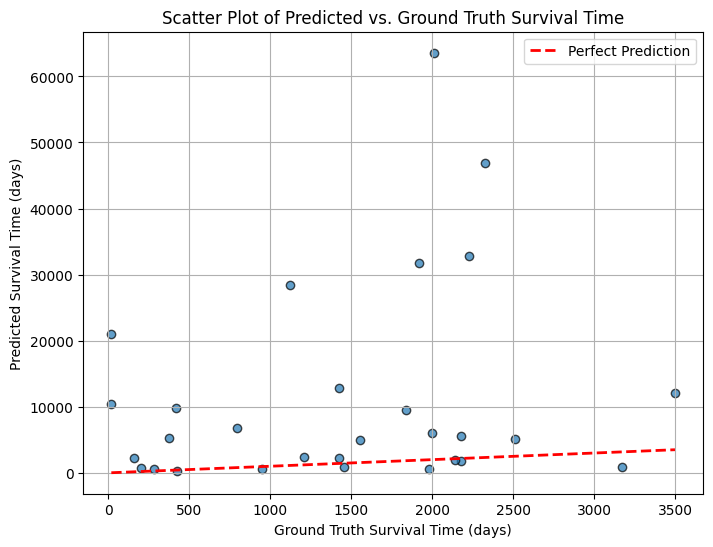

In [21]:
# Giả sử bạn có dữ liệu ground truth và predicted survival time
# Thay thế bằng dữ liệu thực tế của bạn
ground_truth = np.array(df_test['Time to Event'])
predicted = np.array(expectation_prediction)

plt.figure(figsize=(8, 6))
plt.scatter(ground_truth, predicted, alpha=0.7, edgecolors='k')
plt.plot([ground_truth.min(), ground_truth.max()], [ground_truth.min(), ground_truth.max()], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Ground Truth Survival Time (days)")
plt.ylabel("Predicted Survival Time (days)")
plt.title("Scatter Plot of Predicted vs. Ground Truth Survival Time")
plt.legend()
plt.grid(True)
plt.show()